<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files%20/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown  # To download files from Google Drive
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=5905c500-b006-4e46-ac51-a61e61fab62d
To: /content/dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 80.8MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Total available samples: 60000
Training data shape: (48000, 784)
Test data shape: (12000, 784)


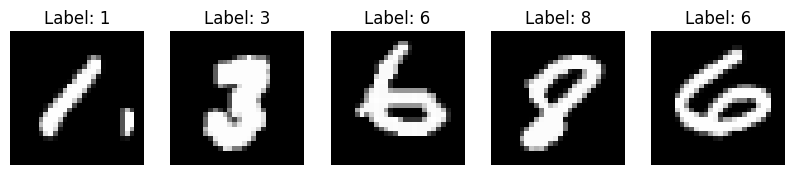

In [2]:
# File ID from Google Drive
file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output = "dataset.csv"
gdown.download(url, output, quiet=False)

# Read CSV into Pandas DataFrame
df = pd.read_csv(output, header=None)  # No header in the dataset

# Preview dataset structure
print(df.head())

# Extract labels (first column) and features (remaining columns)
y = df.iloc[:, 0].values  # Labels
X = df.iloc[:, 1:].values  # Features (pixel values)

# Normalize pixel values (0-255 → 0-1)
X = X / 255.0

# Check available dataset size
total_samples = X.shape[0]
print(f"Total available samples: {total_samples}")

# Define split ratios
train_ratio = 0.8  # Use 80% for training, 20% for testing
train_size = int(total_samples * train_ratio)
test_size = total_samples - train_size  # Remaining for testing

# Split dataset while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42
)

# Verify shapes
print(f"Training data shape: {X_train.shape}")  # Should be around 80% of total samples
print(f"Test data shape: {X_test.shape}")       # Should be around 20% of total samples

# Check if reshaping to 28x28 is valid
num_features = X.shape[1]
image_size = int(np.sqrt(num_features))

if image_size * image_size == num_features:
    # Display some sample images
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(X_train[i].reshape(image_size, image_size), cmap="gray")
        ax.set_title(f"Label: {y_train[i]}")
        ax.axis("off")

    plt.show()
else:
    print(f"Warning: Cannot reshape images to ({image_size}, {image_size}). Check dataset dimensions.")

Accuracy: 96.73%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

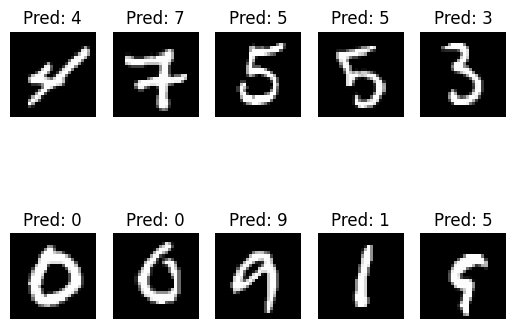

In [3]:
# MNIST Dataset Load Karna
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier Train Karna
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Model Save Karna
with open('MNIST_RFC.pickle', 'wb') as f:
    pickle.dump(clf, f)

# Predictions
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Random 10 Images Predict Karna
random_indices = np.random.randint(0, len(X_test), 10)
for i, idx in enumerate(random_indices):
    img = X_test.iloc[idx].to_numpy().reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {clf.predict([X_test.iloc[idx]])[0]}')
    plt.axis('off')

plt.show()
